In [1]:
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    Settings,
    ServiceContext,
    StorageContext,
    load_index_from_storage,
)
from llama_index.core.embeddings.utils import resolve_embed_model
from llama_index.llms.ollama import Ollama
from llama_index.core import VectorStoreIndex, get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core import Settings
from llama_index.core.node_parser.text.sentence import SentenceSplitter

from transformers import AutoTokenizer

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from llama_cpp import Llama
from llama_cpp import LlamaGrammar

from pathlib import Path
import random
import json
import shutil

In [16]:
GENERATE_METHODS_DIR = Path('data/docs/manual')
METHODS_DIR = Path('data/docs/methods')
PROMPT_SEEDS_DIR = Path('data/prompts/generation/components')
PROMPT_COMPONENTS_DIR = Path('data/prompts/generation/components')
VAL_PROMPT_COMPONENTS_DIR = Path('data/prompts/validation/components')
GEN_PROMPTS_DIR = Path('data/prompts/generation/output')
VAL_PROMPTS_DIR = Path('data/prompts/validation/output')
PERSIST_DIR = Path("data/persist_dir")
OUTPUT_DIR = Path("output/")
DATASET_PATH = Path('data/datasets/dataset_v5.csv')
MODELS_PATH = Path('models/')

# index generation & loading

In [3]:
# default tokenizer is for gpt-3.5
# llama_index.core.global_tokenizer

In [4]:
# documents = SimpleDirectoryReader(METHODS_DIR).load_data()

# embed_tokenizer = AutoTokenizer.from_pretrained(
#     "BAAI/bge-base-en-v1.5"
# )
# Settings.text_splitter = SentenceSplitter(chunk_size=768, tokenizer=embed_tokenizer)

# Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# index = VectorStoreIndex.from_documents(
#     documents, show_progress=True
# )

# index.storage_context.persist(persist_dir=PERSIST_DIR)

In [5]:
Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)

# load index
index = load_index_from_storage(storage_context, show_progress=True)

In [6]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=3,
)

# check index

In [7]:
# Assuming you have an instance of TreeIndex named tree_index
ref_doc_info = index.ref_doc_info

# Now you can iterate over the ref_doc_info to view each node's details
with open('temp/index.txt', 'w') as f:
    for node_id, node_info in ref_doc_info.items():
        f.write(f"Node ID: {node_id}\n")
        f.write(f"Node Info: {node_info}\n")

In [8]:
# r = retriever.retrieve('Get status of a cover.')
# print(r)

# llm loading (skip)

In [16]:
llm = Llama('models/mistral-7b-instruct-v0.2.Q6_K.gguf', n_ctx=4000, verbose=False, n_gpu_layers=25) # mistral-7b-instruct-v0.2.Q4_0.gguf mistral-7b-instruct-v0.2.Q4_K_M.gguf

In [10]:
prompt = """
Command: Please, close the living room blinds slowly for 20 seconds.

What is the function user want to call in smart home?
"""
llm.create_chat_completion(messages=[{'role': 'user', 'content': prompt}], max_tokens=100)

{'id': 'chatcmpl-d1b9eec8-3fc0-4fcb-b44d-6ec5a8015809',
 'object': 'chat.completion',
 'created': 1711724514,
 'model': 'models/mistral-7b-instruct-v0.2.Q6_K.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': " The user wants to call a function to close the living room blinds gradually over a period of 20 seconds in their smart home system. This can typically be achieved by using an automation or scene feature within the smart home app, allowing the user to control the blinds' closing speed and duration."},
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 43, 'completion_tokens': 62, 'total_tokens': 105}}

In [19]:
!nvidia-smi

Wed Apr  3 14:34:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 26%   36C    P2    52W / 215W |   1250MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# prompt preparation

In [7]:
def get_base_prompt_variables():
    json_scheme_prompt = {
        "method": {
            "type": "string"
        },
        "params": {
            "type": "object"
        }
    }

    example_1_json = {
      "method":"Cover.Open",
      "params":
      {
        "id":2
      }
    }

    example_2_json = {
      "method":"Cover.Close",
      "params":
      {
        "id":100,
        "duration":5,
      }
    }

    with open(VAL_PROMPT_COMPONENTS_DIR / 'instruction.md') as f:
      instruction = f.read()

    variables = {
    "instruction": instruction,
    "json_scheme": "The output JSON should follow the next scheme: " + json.dumps(json_scheme_prompt),
    "example_1": """Devices: Smoke id=15, Cover id=2, Temperature id=10
Methods:
API method 1:
Method name: Cover.Open
Method description: 
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it times out because of maxtime_open first. If duration (seconds) is provided, Cover will move in the open direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; error if the request can not be executed or failed

Command: Open the cover.
JSON: """ + json.dumps(example_1_json),

    "example_2": """Devices: Cover id=100, Light id=5, Switch id=7, Smoke id=120
Methods: 
API method 1:
Method name: Cover.Close
Method description:
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully close, unless it times out because of maxtime_close first. If duration (seconds) is provided, Cover will move in the close direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; error if the request can not be executed or failed

Command: Close the kitchen cover quickly (for 5 seconds).
JSON: """ + json.dumps(example_2_json),
    }

    return variables

In [8]:
def get_base_prompt():
    base_prompt_template = """
{instruction}
{json_scheme}

{example_1}

{example_2}
    """

    variables = get_base_prompt_variables()

    base_prompt = base_prompt_template.format(**variables)

    return base_prompt

def get_user_prompt_template():
    user_prompt_template = """Devices: {env}
Methods:
{methods_description}

Command: {user_cmd}
JSON:
    """

    return user_prompt_template

print(get_base_prompt())


You are a helpful AI Assistant that controls devices in a house. For a given user command create a corresponding JSON object. In any case you mustn't include JSON fields that equal null because null will break the smart home system. Don't include field instead of setting field to null. Output must be strictly in JSON format.
The output JSON should follow the next scheme: {"method": {"type": "string"}, "params": {"type": "object"}}

Devices: Smoke id=15, Cover id=2, Temperature id=10
Methods:
API method 1:
Method name: Cover.Open
Method description: 
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it times out because of maxtime_open first. If duration (seconds) is provided, Cover will move in the open direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; erro

# logging

In [9]:
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# logger = logging.getLogger()
# logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [10]:
# logger.disabled = True

# predict functions

In [11]:
def predict_prompt(llm, prompt, grammar=None):
    response = llm.create_chat_completion(
        messages=[
            {'role': 'user', 'content': prompt}
        ],
        grammar=grammar
    )
    
    response_text = response['choices'][0]['message']['content']
    response_text = response_text.replace('\_', '_')

    try:
        json_cmd = json.dumps(json.loads(response_text))
    except Exception as e:
        print(e)
        print(response_text)
        return ""

    return json_cmd

def get_methods_description(retrieved_nodes):
    methods_names = []
    methods_description = ''
    for k, node in enumerate(retrieved_nodes):
        methods_description += f'API method {k}:\n{node.text}\n\n'
        method_name = node.metadata['file_name'].replace('.md', '')
        methods_names.append(method_name)

    methods_names = ','.join(methods_names)
    methods_description = methods_description.strip('\n')

    return methods_names, methods_description

def predict(llm, df, run_name, num_nodes=3, selected_devices=None, selected_ids=None, limit_rows=None, verbose=False):
    output_path = OUTPUT_DIR / run_name / 'output.csv'

    with open('data/grammars/json.gbnf') as f:
        grammar_str = f.read()
    llama_grammar = LlamaGrammar.from_string(grammar_str, verbose=False)

    # before filtering because we need a whole list of devices
    devices = list(df['device'].unique())

    if selected_devices:
        df = df[df['device'].isin(selected_devices)].sort_index()
    
    if selected_ids:
        df = df[df['id'].isin(selected_ids)]

    if limit_rows:
        df = df.iloc[:limit_rows]

    output_df = pd.DataFrame(columns=['id', 'device', 'user_cmd', 'mtd', 'json_cmd'])
    for i, row in df.iterrows():
        print(i)
        user_cmd = row['user_cmd']

        device = row['device']
        sample_devices = devices.copy()
        sample_devices.remove(device)
        sample_devices = random.sample(sample_devices, k=2)
        env = f'{sample_devices[0]} id=8, {sample_devices[1]} id=13, {device} id=444'

        retrieval_prompt = "Represent this sentence for searching relevant passages: " + user_cmd
        retrieved_nodes = retriever.retrieve(retrieval_prompt)
        
        completed = False
        while (not completed) and (num_nodes > 0):
            try:
                methods_names, methods_description = get_methods_description(retrieved_nodes[:num_nodes])

                user_prompt = get_user_prompt_template().format(**{'env': env, 
                                                            'methods_description': methods_description, 
                                                            'user_cmd': user_cmd})
                prompt = get_base_prompt() + '\n\n' + user_prompt

                json_cmd = predict_prompt(llm, prompt, llama_grammar)

                completed = True
            except Exception as e:
                print(e)

                num_nodes -= 1
        
        if verbose:
            print(f'{prompt}\n')
            print('<<<------------------------------------------>>>\n\n')
        
        if json_cmd == "":
            continue

        output_series = pd.Series({'id': row['id'], 'device': row['device'], 'user_cmd': user_cmd, 'mtd': methods_names, 'json_cmd': json_cmd})
        output_df.loc[len(output_df)] = output_series

        if i == df.index[0]:
            header = True
            mode = 'w'
        else:
            header = False
            mode = 'a'
        output_df.iloc[[len(output_df)-1]].to_csv(output_path, index=False, header=header, mode=mode)
    
    return output_df

# evaluation functions

In [12]:
# necessary properties are absent
# returns True if check failed
def check_necessary_parameters(gt_json, pred_json):
    for key, val in gt_json.items():
        if key not in pred_json:
            return True
        if type(val) == dict:
            if check_necessary_parameters(val, pred_json[key]):
                return True
    return False

# some additional from method doc (with or without necessary)
def check_additional_parameters(gt_json, pred_json, json_scheme):
    for key, val in pred_json.items():
        if key not in json_scheme:
                continue
        if key not in gt_json:
            return True
        if type(val) == dict:
            try:
                if check_additional_parameters(val, gt_json[key], json_scheme[key]['properties']):
                    return True
            except Exception as e:
                print(e)
                print(key, pred_json, gt_json, json_scheme, sep='\n')
    return False

# hallucinated properties that aren’t described in method doc
def check_hallucinated_parameters(pred_json, json_scheme):
    for key, val in pred_json.items():
        if key not in json_scheme:
            return True
        if type(val) == dict:
            if check_hallucinated_parameters(val, json_scheme[key]['properties']):
                return True
    return False

# incorrect value of parameter from prediction
def check_correctness_parameters(gt_json, pred_json):
    for key, val in pred_json.items():
        if key not in gt_json:
                continue
        if type(val) == dict:
            if check_correctness_parameters(val, gt_json[key]):
                return True
        elif gt_json[key] != val:
            return True
    return False

def check_correctness_json(gt_json, pred_json):
    return gt_json == pred_json

def compare_gt_pred(output_df, gt_df):
    merged_df = gt_df.merge(output_df, how='inner', on='id', suffixes=("_gt", "_pred"))
    json_schemes_df = pd.read_csv(METHODS_DIR.parent / 'methods_json.csv')
    compared_df = pd.DataFrame(columns=['id', 'device', 'user_cmd', 'gt_mtd', 'pred_mtd', 'gt_json_cmd', 'pred_json_cmd',
                                               'retriever_cor', 'json_cor', 'add', 'hall', 'absent', 'incor'])
    for _, row in merged_df.iterrows():
        methods_names_pred = row['mtd_pred'].split(',')
        try:
            gt_json = json.loads(row['json_cmd_gt'])
            pred_json = json.loads(row['json_cmd_pred'])
        except Exception as ex:
            print(ex)
            print(row['id'])
            print(row['json_cmd_gt'])
            print(row['json_cmd_pred'])
            continue
        method_name = pred_json['method']
        method_df = json_schemes_df[json_schemes_df['method'] == method_name]
        if method_df.shape[0] == 0:
            json_scheme = None
        else:
            json_scheme = json.loads(method_df.iloc[0]['json'])
        compared_dict = {'id': row['id'], 'device': row['device_gt'],
            'user_cmd': row['user_cmd_gt'], 'gt_mtd': row['mtd_gt'],
            'pred_mtd': row['mtd_pred'], 'gt_json_cmd': row['json_cmd_gt'], 'pred_json_cmd': row['json_cmd_pred']}
        
        compared_dict['retriever_cor'] = row['mtd_gt'] in methods_names_pred
        compared_dict['json_cor'] = check_correctness_json(gt_json, pred_json)
        compared_dict['absent'] = check_necessary_parameters(gt_json, pred_json)
        compared_dict['incor'] = check_correctness_parameters(gt_json, pred_json)
        if json_scheme:
            compared_dict['add'] = check_additional_parameters(gt_json, pred_json, json_scheme)
            compared_dict['hall'] = check_hallucinated_parameters(gt_json, json_scheme)
        else:
            compared_dict['add'] = False
            compared_dict['hall'] = False

        compared_df.loc[len(compared_df)] = pd.Series(compared_dict)
    return compared_df

In [18]:
def evaluate(gt_df, output_df, run_name, settings, save_intermediate=False, verbose=False):
    compared_df = compare_gt_pred(output_df, gt_df)
    if save_intermediate:
        compared_df.to_csv(OUTPUT_DIR / run_name / 'compared.csv', index=False)
    if verbose:
        print(len(gt_df))
        print(len(compared_df))

    results_df = pd.DataFrame(columns=['run_name', 'settings', 'method_acc', 'json_acc'])

    method_acc = compared_df[compared_df['retriever_cor'] == True].shape[0] / compared_df.shape[0]
    json_acc = compared_df[compared_df['json_cor'] == True].shape[0] / compared_df.shape[0]
    results_df.loc[0] = pd.Series({'run_name': run_name,
                                    'settings': json.dumps(settings),
                                    'method_acc': method_acc,
                                    'json_acc': json_acc})
    results_df.to_csv(OUTPUT_DIR / 'results.csv', index=False, header=not (OUTPUT_DIR / 'results.csv').exists(), mode='a')

    fail_reasons_df = compared_df[compared_df['retriever_cor'] == True].copy(deep=True)
    fail_reasons_df = fail_reasons_df.loc[:, ['gt_mtd', 'retriever_cor', 'json_cor', 'add', 'hall', 'absent', 'incor']]
    fail_reasons_df.rename(columns={'gt_mtd': 'method'}, inplace=True)
    fail_reasons_df = fail_reasons_df.replace({True: 1, False: 0})
    fail_reasons_df = fail_reasons_df.groupby('method', as_index=False).sum()
    fail_reasons_df.insert(0, 'run_name', run_name)
    fail_reasons_df.to_csv(OUTPUT_DIR / 'fail_reasons.csv', index=False, header=not (OUTPUT_DIR / 'fail_reasons.csv').exists(), mode='a')

# plot functions

In [14]:
def plot_results(run_names):
    df = pd.read_csv(OUTPUT_DIR / 'results.csv')
    df = df[df['run_name'].isin(run_names)]
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

    sns.barplot(data=df, x="run_name", y="method_acc", ax=axs[0])
    axs[0].set(xlabel='Run', ylabel='', title="Retriever accuracy")
    axs[0].tick_params(axis='x', rotation=45)

    sns.barplot(data=df, x="run_name", y="json_acc", ax=axs[1])
    axs[1].set(xlabel='Run', ylabel='', title="LLM accuracy")
    axs[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    plt.show()

In [15]:
def plot_fail_reasons(run_names):
    df = pd.read_csv(OUTPUT_DIR / 'fail_reasons.csv')
    df = df[df['run_name'].isin(run_names)]
    df['method'] = df['method'].apply(lambda x: x.split('.')[1])
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    ymax = 20

    order = df.groupby('method')['add'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="add", hue="run_name", estimator='sum', order=order, ax=axs[0][0], errorbar=None)
    axs[0][0].set(xlabel='', ylabel='', title="Additional parameters", ylim=(0, ymax))
    axs[0][0].tick_params(axis='x', rotation=90)
    
    order = df.groupby('method')['hall'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="hall", hue="run_name", estimator='sum', order=order, ax=axs[0][1], errorbar=None)
    axs[0][1].set(xlabel='', ylabel='', title="Hallucinated parameters", ylim=(0, ymax))
    axs[0][1].tick_params(axis='x', rotation=90)

    order = df.groupby('method')['absent'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="absent", hue="run_name", estimator='sum', order=order, ax=axs[1][0], errorbar=None)
    axs[1][0].set(xlabel='', ylabel='', title="Absent parameters", ylim=(0, ymax))
    axs[1][0].tick_params(axis='x', rotation=90)

    order = df.groupby('method')['incor'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="incor", hue="run_name", estimator='sum', order=order, ax=axs[1][1], errorbar=None)
    axs[1][1].set(xlabel='', ylabel='', title="Incorrect parameters", ylim=(0, ymax))
    axs[1][1].tick_params(axis='x', rotation=90)

    sns.despine()
    fig.tight_layout()
    plt.show()

# validate

In [16]:
MODELS = {
    'mistral-7b': 'mistral-7b-instruct-v0.2.Q6_K.gguf'
}

In [18]:
gt_df = pd.read_csv(DATASET_PATH)
RUN_NAME = 'baseline'
NUM_EXAMPLES = 2
NUM_NODES = 3
MODEL_NAME = 'mistral-7b'
N_CTX = 4000

settings = {
    'llm': MODEL_NAME,
    'num_examples': 2,
    'num_nodes': NUM_NODES,
    'num_examples': NUM_EXAMPLES,
    'n_ctx': N_CTX
}

(OUTPUT_DIR / RUN_NAME).mkdir(exist_ok=True)

with open(OUTPUT_DIR / RUN_NAME / "settings.json", 'w') as f:
    f.write(json.dumps(settings))
shutil.copy(VAL_PROMPT_COMPONENTS_DIR / 'instruction.md', OUTPUT_DIR / RUN_NAME)

if 'llm' in locals():
    del llm
llm = Llama(str(MODELS_PATH / MODELS[MODEL_NAME]), n_ctx=N_CTX, verbose=False, n_gpu_layers=25)

output_df = predict(llm, gt_df, RUN_NAME, num_nodes=NUM_NODES, verbose=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
Requested tokens (4372) exceed context window of 4000
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


# evaluate

In [19]:
gt_df = pd.read_csv(DATASET_PATH)
RUN_NAME = 'baseline'

output_df = pd.read_csv(OUTPUT_DIR / RUN_NAME / 'output.csv')

with open(OUTPUT_DIR / RUN_NAME / 'settings.json') as f:
    settings = f.read()
settings = json.loads(settings)

evaluate(gt_df, output_df, RUN_NAME, settings, save_intermediate=True)

/tmp/ipykernel_1234759/751254329.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fail_reasons_df = fail_reasons_df.replace({True: 1, False: 0})


In [20]:
plot_results(['baseline'])

KeyError: 'run_name'

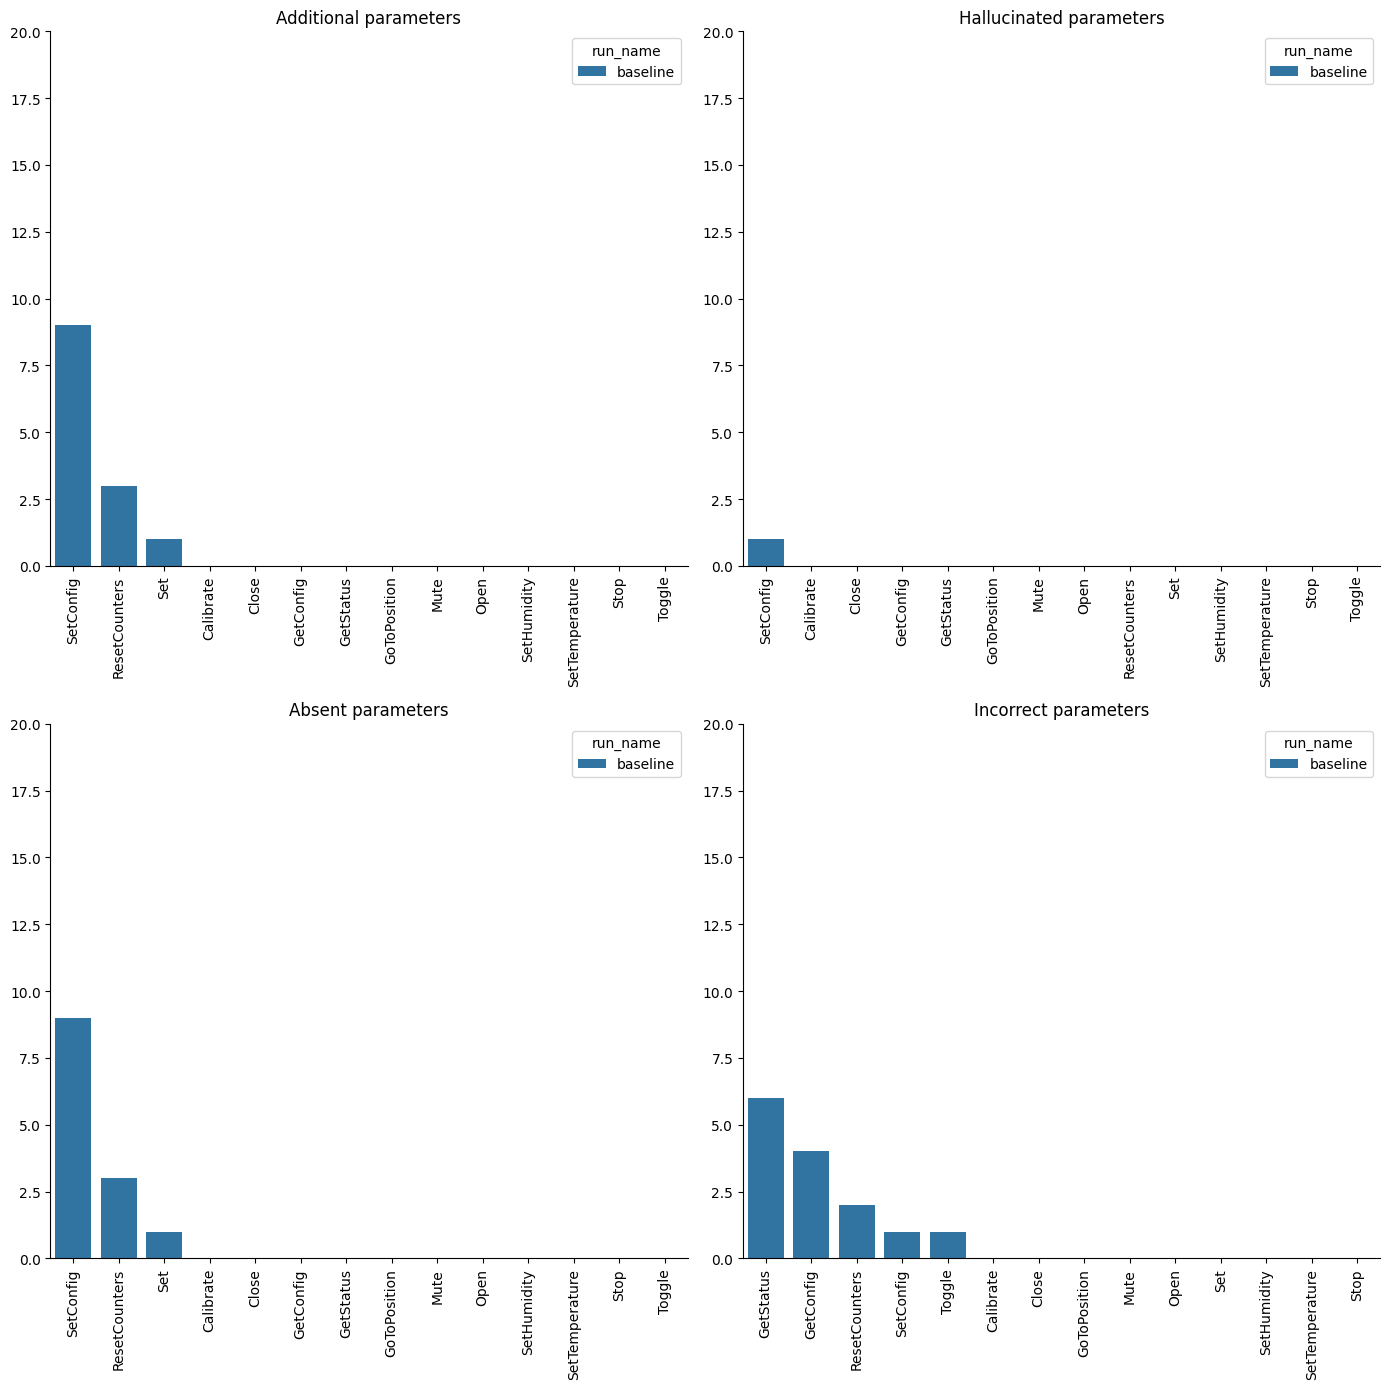

In [22]:
plot_fail_reasons(['baseline'])

In [8]:
df = pd.read_csv(OUTPUT_DIR / 'baseline/compared.csv')
display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round(x['add'].value_counts()[False] / x.shape[0], 2)).sort_values(ascending=True))
display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round(x['absent'].value_counts()[False] / x.shape[0], 2)).sort_values(ascending=True))
display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round(x['incor'].value_counts()[False] / x.shape[0], 2)).sort_values(ascending=True))

/tmp/ipykernel_1234759/1404416075.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round(x['add'].value_counts()[False] / x.shape[0], 2)).sort_values(ascending=True))


gt_mtd
Input.ResetCounters           0.33
Light.Set                     0.50
Cover.SetConfig               0.50
Cover.ResetCounters           0.67
Input.SetConfig               0.71
Light.SetConfig               0.80
Temperature.SetConfig         0.83
Switch.SetConfig              0.86
Humidity.SetConfig            0.88
Light.Toggle                  1.00
Smoke.GetConfig               1.00
Smoke.GetStatus               1.00
Cover.Calibrate               1.00
Switch.GetConfig              1.00
Switch.GetStatus              1.00
Switch.ResetCounters          1.00
Switch.Toggle                 1.00
Temperature.GetConfig         1.00
Temperature.GetStatus         1.00
Smoke.Mute                    1.00
Smoke.SetConfig               1.00
Light.GetConfig               1.00
Light.GetStatus               1.00
Light.Calibrate               1.00
Input.GetStatus               1.00
Input.GetConfig               1.00
Humidity.SetHumidity          1.00
Humidity.GetStatus            1.00
Humidity.GetC

/tmp/ipykernel_1234759/1404416075.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round(x['absent'].value_counts()[False] / x.shape[0], 2)).sort_values(ascending=True))


gt_mtd
Input.ResetCounters           0.33
Cover.SetConfig               0.50
Light.Set                     0.50
Light.SetConfig               0.60
Cover.ResetCounters           0.67
Input.SetConfig               0.71
Smoke.SetConfig               0.75
Switch.SetConfig              0.86
Cover.Calibrate               1.00
Light.Toggle                  1.00
Smoke.GetConfig               1.00
Smoke.GetStatus               1.00
Switch.GetConfig              1.00
Switch.GetStatus              1.00
Switch.ResetCounters          1.00
Switch.Toggle                 1.00
Temperature.GetConfig         1.00
Temperature.GetStatus         1.00
Smoke.Mute                    1.00
Light.ResetCounters           1.00
Light.GetConfig               1.00
Temperature.SetConfig         1.00
Light.Calibrate               1.00
Input.GetStatus               1.00
Input.GetConfig               1.00
Humidity.SetHumidity          1.00
Humidity.SetConfig            1.00
Humidity.GetStatus            1.00
Humidity.GetC

/tmp/ipykernel_1234759/1404416075.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(df[df['retriever_cor'] == True].groupby(by='gt_mtd').apply(lambda x: round(x['incor'].value_counts()[False] / x.shape[0], 2)).sort_values(ascending=True))


gt_mtd
Switch.ResetCounters          0.33
Cover.GetStatus               0.57
Cover.GetConfig               0.67
Switch.Toggle                 0.67
Light.GetStatus               0.75
Smoke.GetConfig               0.80
Input.SetConfig               0.86
Light.GetConfig               0.88
Humidity.GetConfig            0.88
Input.GetStatus               0.88
Light.SetConfig               1.00
Light.Toggle                  1.00
Smoke.GetStatus               1.00
Switch.GetConfig              1.00
Smoke.SetConfig               1.00
Switch.GetStatus              1.00
Switch.SetConfig              1.00
Temperature.GetConfig         1.00
Temperature.GetStatus         1.00
Smoke.Mute                    1.00
Light.Set                     1.00
Cover.Calibrate               1.00
Temperature.SetConfig         1.00
Light.Calibrate               1.00
Input.ResetCounters           1.00
Input.GetConfig               1.00
Humidity.SetHumidity          1.00
Humidity.SetConfig            1.00
Humidity.GetS

In [6]:
df[(df['retriever_cor'] == True) & (df['gt_mtd'] == 'Cover.SetConfig')]

,id,device,user_cmd,gt_mtd,pred_mtd,gt_json_cmd,pred_json_cmd,retriever_cor,json_cor,add,hall,absent,incor
85,88,Cover,Set the power limit of the cover to 500 W with a voltage limit of 200 V.,Cover.SetConfig,"Cover.SetConfig,Cover.GetConfig,Cover.Calibrate","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""power_limit"": 500, ""voltage_limit"": 200}}}","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""power_limit"": 500, ""voltage_limit"": 200}}}",True,True,False,False,False,False
86,89,Cover,Set the obstruction detection power threshold to 800 W and the holdoff time to 5 seconds.,Cover.SetConfig,"Cover.SetConfig,Switch.GetStatus,Light.Set","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""obstruction_detection"": {""power_thr"": 800, ""holdoff"": 5}}}}","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""motor"": {""obstruction_detection"": {""power_thr"": 800, ""holdoff"": 5}}}}}",True,False,True,False,True,False
196,200,Cover,Set the under voltage limit to 20 volts for the cover.,Cover.SetConfig,"Cover.SetConfig,Cover.GetConfig","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""undervoltage_limit"": 20}}}","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""power_limit"": null, ""voltage_limit"": 20}}}",True,False,True,False,True,False
197,201,Cover,Can you enable the safety switch feature for the cover?,Cover.SetConfig,"Cover.Calibrate,Cover.SetConfig","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""safety_switch"": {""enable"": true}}}}","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""obstruction_detection"": {""enable"": true}}}}",True,False,True,False,True,False
198,202,Cover,Set the initial state of the cover to open on power-on.,Cover.SetConfig,"Cover.SetConfig,Cover.GetStatus","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""initial_state"": ""open""}}}","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""initial_state"": ""open""}}}",True,True,False,False,False,False
199,203,Cover,Set the idle power threshold of the motor to 50 watts for the cover.,Cover.SetConfig,"Cover.SetConfig,Cover.GetConfig","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""motor"": {""idle_power_thr"": 50}}}}","{""method"": ""Cover.SetConfig"", ""params"": {""id"": 444, ""config"": {""motor"": {""idle_power_thr"": 50}}}}",True,True,False,False,False,False


In [9]:
df[(df['retriever_cor'] == True) & (df['gt_mtd'] == 'Cover.GetConfig')]

,id,device,user_cmd,gt_mtd,pred_mtd,gt_json_cmd,pred_json_cmd,retriever_cor,json_cor,add,hall,absent,incor
36,36,Cover,Retrieve the configuration of the bedroom shades.,Cover.GetConfig,"Light.GetConfig,Light.SetConfig,Cover.GetConfig","{""method"": ""Cover.GetConfig"", ""params"": {""id"": 444}}","{""method"": ""Cover.GetConfig"", ""params"": {""id"": 444}}",True,True,False,False,False,False
38,38,Cover,Check the setup of the patio cover.,Cover.GetConfig,"Cover.GetStatus,Cover.GetConfig,Cover.SetConfig","{""method"": ""Cover.GetConfig"", ""params"": {""id"": 444}}","{""method"": ""Cover.GetConfig"", ""params"": {""id"": 444}}",True,True,False,False,False,False
42,42,Cover,Check the config of the study cover configuration.,Cover.GetConfig,"Cover.SetConfig,Cover.GetConfig,Cover.Calibrate","{""method"": ""Cover.GetConfig"", ""params"": {""id"": 444}}","{""method"": ""Cover.GetConfig"", ""params"": {""id"": 8}}",True,False,False,False,False,True


In [11]:
df[(df['retriever_cor'] == True) & (df['gt_mtd'] == 'Light.GetStatus')]

,id,device,user_cmd,gt_mtd,pred_mtd,gt_json_cmd,pred_json_cmd,retriever_cor,json_cor,add,hall,absent,incor
57,58,Light,Check the status of the main light.,Light.GetStatus,"Light.GetStatus,Cover.GetStatus,Switch.GetStatus","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}",True,True,False,False,False,False
58,59,Light,What is the current brightness level of the bedroom light?,Light.GetStatus,"Light.GetStatus,Light.Set,Light.GetConfig","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}",True,True,False,False,False,False
59,60,Light,Get the total energy consumed by the main light.,Light.GetStatus,"Light.GetStatus,Light.ResetCounters,Light.GetConfig","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetConfig"", ""params"": {""id"": 444, ""type"": [""aenergy""]}}",True,False,False,False,False,True
60,61,Light,Check if the output channel is currently on for the main light.,Light.GetStatus,"Light.GetStatus,Switch.GetStatus,Light.Toggle","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}",True,True,False,False,False,False
61,62,Light,What are the errors occurred in the light component?,Light.GetStatus,"Light.GetConfig,Light.SetConfig,Light.GetStatus","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444, ""errors"": {""type"": ""array"", ""description"": ""Error conditions occurred, shown if at least one error is present""}}}",True,False,False,False,False,False
62,63,Light,Get the info about the temperature of the light.,Light.GetStatus,"Temperature.GetStatus,Light.GetStatus,Temperature.GetConfig","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}",True,True,False,False,False,False
63,64,Light,Obtain the last measured voltage of the main light.,Light.GetStatus,"Light.GetStatus,Light.GetConfig,Switch.GetStatus","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}",True,True,False,False,False,False
64,65,Light,Get the current level of instant active power delivered to the attached load.,Light.GetStatus,"Switch.GetStatus,Light.GetStatus,Cover.GetStatus","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Switch.GetStatus"", ""params"": {""id"": 7}}",True,False,False,False,False,True
